# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import pyhf
import cabinetry
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [2]:
# 4S Dsideband Data vs MC
columns = util.all_relevant_variables
training_variables = util.training_variables

# Load data files
mc = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_local_200fb/*.root:B0'],
                          library="np",
                          #cut = '((D_M>1.79) & (D_M<1.82)) | ((D_M>1.92) & (D_M<1.95))',
                          filter_branch=lambda branch: branch.name in columns)

data = uproot.concatenate([f'../../Samples/Data/e_channel/proc13_4S_Dsb_e_persian_1.root:B0'],
                          library="np",
#                           cut = '((D_M>1.79) & (D_M<1.82)) | ((D_M>1.92) & (D_M<1.95))',
                          filter_branch=lambda branch: branch.name in columns)

df_mc = pd.DataFrame(mc)
df_data = pd.DataFrame(data)

df_mc.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df_mc.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)
df_data.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df_data.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [12]:
# load MVA
import lightgbm as lgb
df_mc_4S_offres_BDT_conti = util.apply_mva_bcs(df_mc_4S_offres, training_variables, BDT_continuum)
df_data_4S_offres_BDT_conti = util.apply_mva_bcs(df_data_4S_offres, training_variables, BDT_continuum)

df_mc_4S_offres_BDT_sig = util.apply_mva_bcs(df_mc_4S_offres, training_variables, BDT_sig)
df_data_4S_offres_BDT_sig = util.apply_mva_bcs(df_data_4S_offres, training_variables, BDT_sig)


bst_lgb = lgb.Booster(model_file=f'../../BDTs/LightGBM/lgbm_multiclass.txt')
cut='signal_prob==largest_prob and signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05'
# mc
pred_mc = bst_lgb.predict(df_mc[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out_mc = pd.DataFrame(pred_mc, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb_mc = pd.concat([df_mc, lgb_out_mc], axis=1)
df_lgb_mc['largest_prob'] = df_lgb_mc[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred_mc, lgb_out_mc

df_cut_mc=df_lgb_mc.query(cut)
df_bestSelected_mc=df_cut_mc.loc[df_cut_mc.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
# data
pred_data = bst_lgb.predict(df_data[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out_data = pd.DataFrame(pred_data, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb_data = pd.concat([df_data, lgb_out_data], axis=1)
df_lgb_data['largest_prob'] = df_lgb_data[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred_data, lgb_out_data

df_cut_data=df_lgb_data.query(cut)
df_bestSelected_data=df_cut_data.loc[df_cut_data.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]

In [25]:
samples=util.get_dataframe_samples_new(df_bestSelected_mc, 'e', template=False)
mpl=util.mpl(samples, df_bestSelected_data)
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 78329
bkg_TDFl 2629
bkg_fakeTracks 1814
bkg_continuum 3110
bkg_combinatorial 8185
bkg_singleBbkg 4584
bkg_other_TDTl 0
$D\tau\nu$ 1574
$D^\ast\tau\nu$ 1072
$D\ell\nu$ 22958
$D^\ast\ell\nu$ 18430
$D^{\ast\ast}\tau\nu$ 663
$D^{\ast\ast}\ell\nu$ 11162
$D\ell\nu$_gap 2830
bkg_other_signal 0


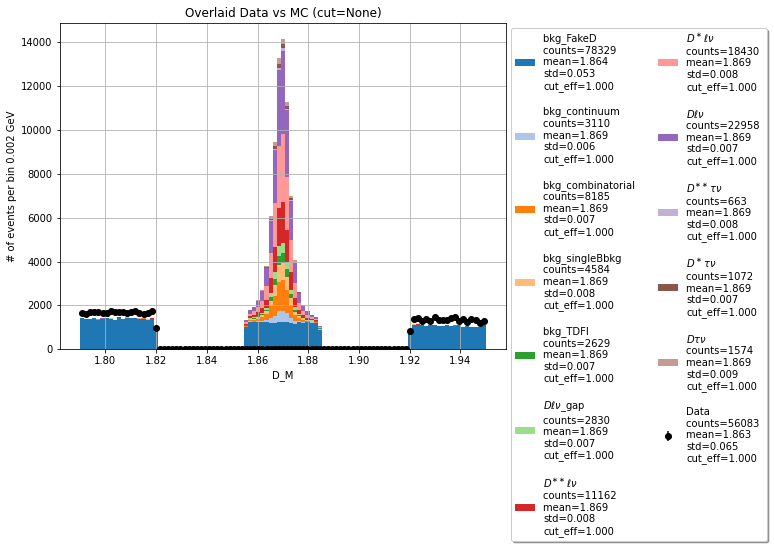

In [26]:
b1 = np.linspace(1.79,1.95,100)
mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut=None,scale=[1,175/200],correction=False,mask=[])

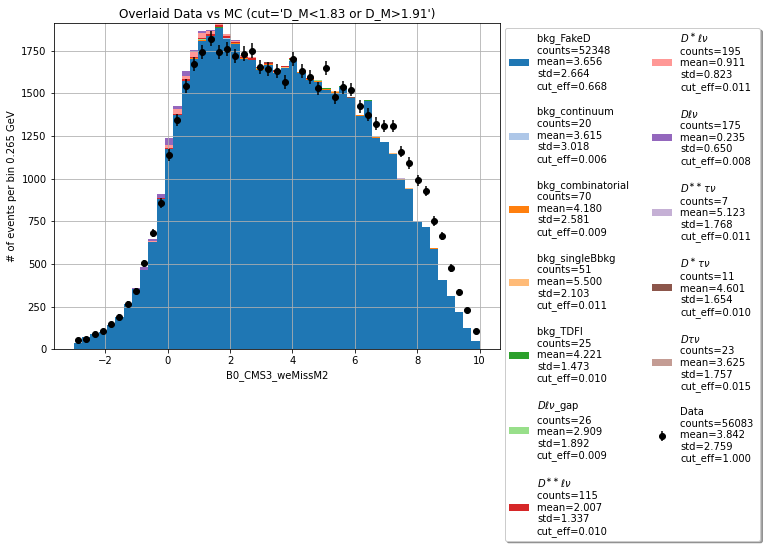

In [49]:
b1 = np.linspace(-3,10,50)
mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,
                          cut='D_M<1.83 or D_M>1.91',
                          scale=[54/56,1],correction=False,mask=[])

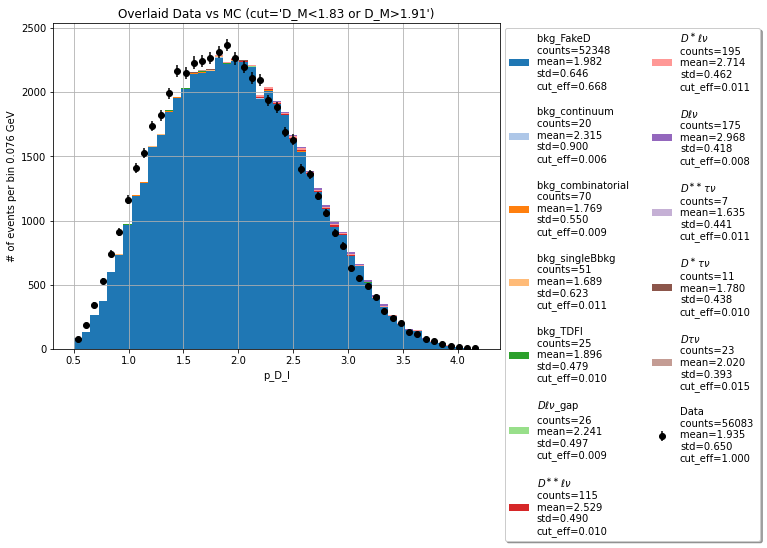

In [50]:
b2 = np.linspace(0.5,4.2,50)
mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,
                          cut='D_M<1.83 or D_M>1.91',
                          scale=[54/56,1],correction=False,mask=[])

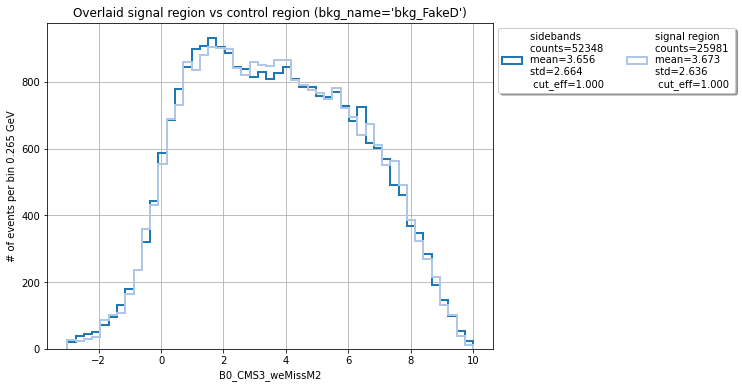

In [41]:
b1 = np.linspace(-3,10,50)
scale = {'left sideband': 260/295/2,
         'signal region': 1,
         'right sideband': 260/228/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=False,mask=[])

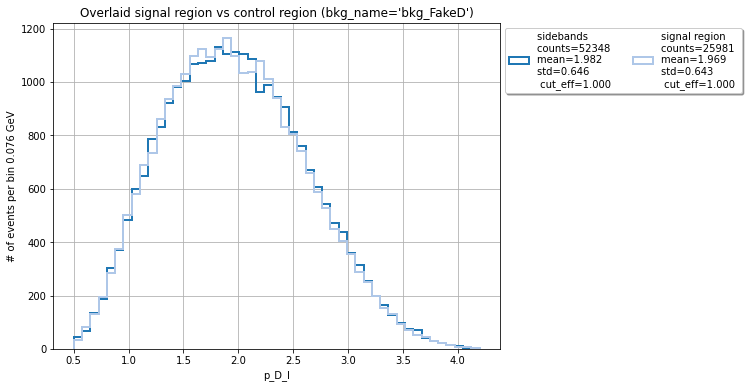

In [43]:
b2 = np.linspace(0.5,4.2,50)
scale = {'left sideband': 260/295/2,
         'signal region': 1,
         'right sideband': 260/228/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_FakeD',cut=None,
                        scale=scale,correction=False,mask=[])

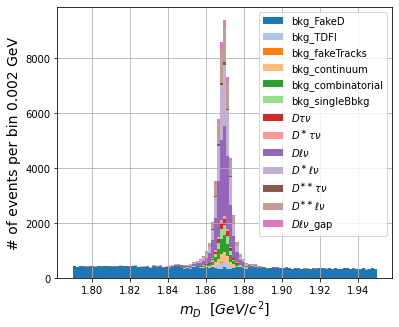

In [11]:
b1 = np.linspace(1.79,1.95,100)
mpl.plot_all_stacked(variable='D_M',bins=b1,cut=None,mask=[])
plt.title('')
plt.xlabel(r'$m_D$  $[GeV/c^2]$',fontsize=14)
plt.legend()

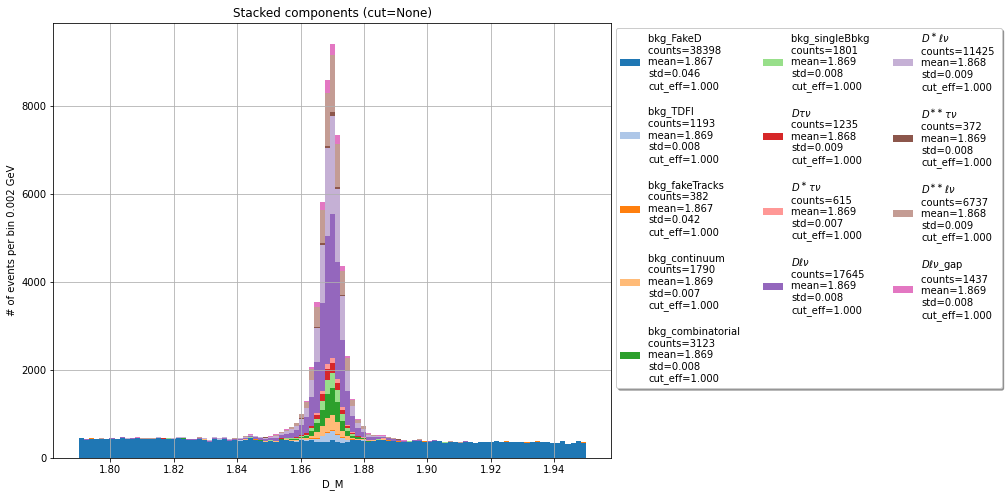

In [6]:
b1 = np.linspace(1.79,1.95,100)
mpl.plot_all_stacked(variable='D_M',bins=b1,cut=None,mask=[])
plt.title('')
plt.legend()

In [12]:
from iminuit import cost, Minuit

def line(x, a, b):
    return a*x + b

bin_edges=np.linspace(1.79,1.95,100)

D_M_values = np.concatenate([df_fakeD_LS['D_M'], df_fakeD_sig['D_M'], df_fakeD_RS['D_M']])

count, bins = np.histogram(D_M_values, bins=bin_edges, density=False)

# Find indices where count is not equal to 0
non_zero_indices = np.where(count != 0)

# Filter both arrays based on non-zero indices
count_filtered = count[non_zero_indices]
bin_edges_filtered = bin_edges[non_zero_indices]

In [13]:
c = cost.LeastSquares(x = bin_edges_filtered, 
                      y = count_filtered, 
                      yerror = np.sqrt(count_filtered), 
                      model = line,
                      loss = 'soft_l1')

m = Minuit(c, a=-12000, b=31000)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 678.7 (chi2/ndof = 12.3)   │              Nfcn = 59               │
│ EDM = 3.02e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ -13.44e3  │  0.24e3   │            │            │         │         │       │
│ 1 │ b    │  33.6e3   │   0.5e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         a         b │
├───┼─────────────────────┤
│ a │  5.97e+04 -1.13e+05 │
│ b │ -1.13e+05  2.13e+05 │
└───┴─────────────────────┘

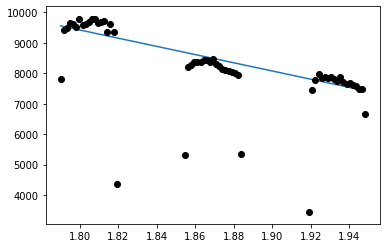

In [14]:
m.visualize()

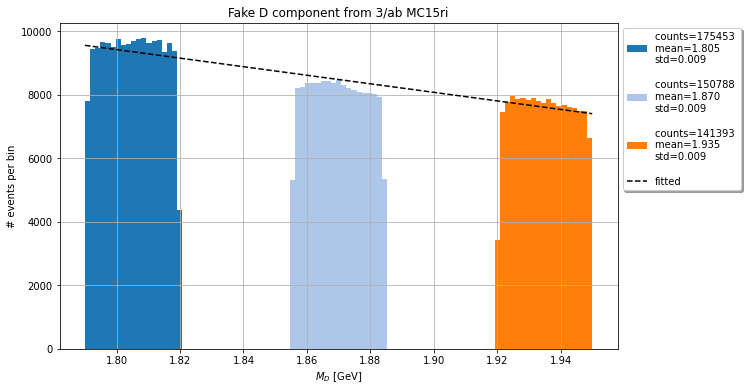

In [17]:
bin_edges=np.linspace(1.79,1.95,100)
plt.figure(figsize=(10, 6))
df_fakeD_LS.D_M.hist(bins=bin_edges, label=statistics(df_fakeD_LS.D_M))
df_fakeD_sig.D_M.hist(bins=bin_edges, label=statistics(df_fakeD_sig.D_M))
df_fakeD_RS.D_M.hist(bins=bin_edges, label=statistics(df_fakeD_RS.D_M))

y = line(bin_edges, a=m.values[0], b=m.values[1])
plt.plot(bin_edges, y, ls="--", label="fitted",color='black')
# plt.errorbar(bin_edges_filtered, count_filtered, np.sqrt(count_filtered), fmt="ok")

plt.title('Fake D component from 3/ab MC15ri')
plt.ylabel('# events per bin')
plt.xlabel('$M_D$ [GeV]')
plt.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1.5)

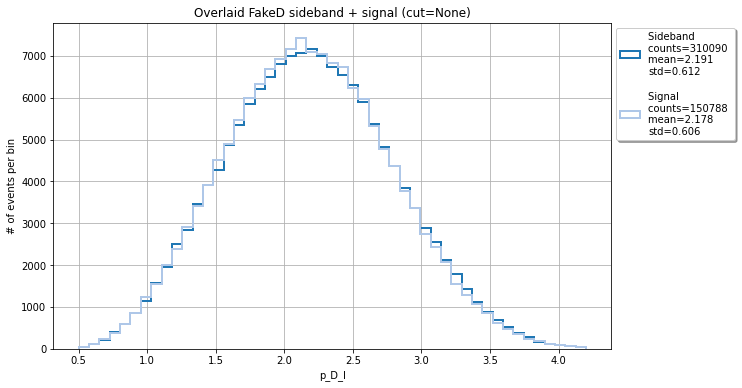

In [10]:
b2 = np.linspace(0.5,4.2,50)
plot_merged_sideband(variable='p_D_l',bins=b2,scale=[15/34, 15/28])

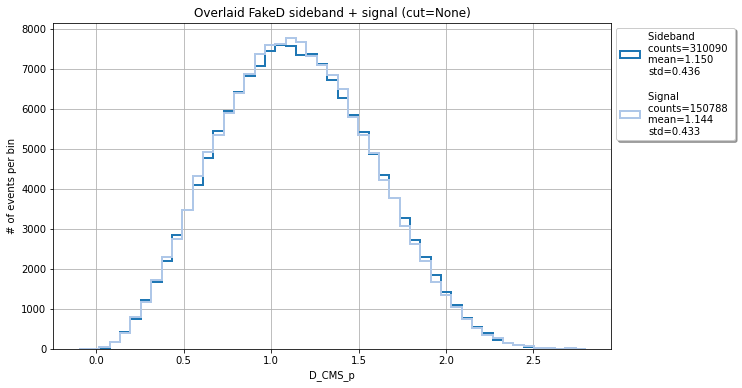

In [13]:
b1 = np.linspace(-0.1,2.8,50)
plot_merged_sideband(variable='D_CMS_p',bins=b1,scale=[15/34, 15/28])

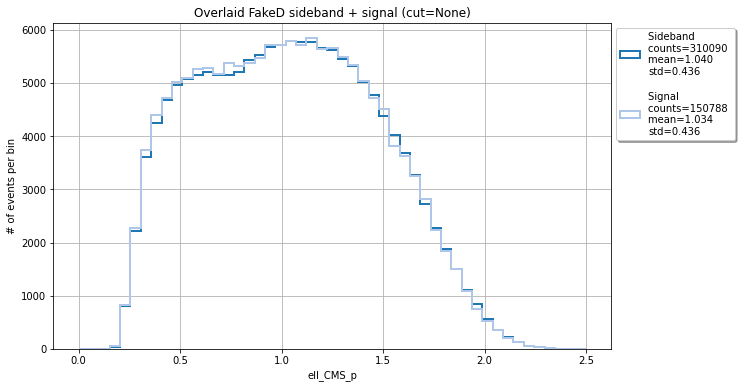

In [11]:
b1 = np.linspace(0,2.5,50)
plot_merged_sideband(variable='ell_CMS_p',bins=b1,scale=[15/34, 15/28])